In [7]:
import pandas as pd 
import os
import numpy as np
import torch
from skimage.io import imread
from sklearn import svm
from skimage.feature import hog
from skimage.segmentation import slic
import torchvision

In [8]:
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
len(df[df.plastic!=-1])

1161

In [9]:
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
df = df[df.plastic!=-1]
df_plastic = df[df.plastic==1].reset_index()
df_noplastic = df[df.plastic==0].reset_index()
len(df_plastic), len(df_noplastic)


(567, 594)

In [10]:
partition = 0.89

rand_ind_p = np.random.randint(0, len(df_plastic), int(partition*len(df_plastic)))
rand_ind_np = np.random.randint(0, len(df_noplastic), int(partition*len(df_noplastic)))

training_set = pd.concat([df_plastic.loc[rand_ind_p, ['patch_filename', 'plastic']], df_noplastic.loc[rand_ind_np, ['patch_filename', 'plastic']]]).reset_index()
validation_set = pd.merge(df.loc[:, ['patch_filename', 'plastic']], training_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge','index'], axis=1).reset_index()

len(training_set), len(validation_set)

(1032, 470)

In [11]:
def prepareData(df):
    data = []
    labels = []
    patches_path = '/home/giorgia/Desktop/MAI/Thesis/images/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        #im = np.amax(imread(patch_filename), axis=2) # maximum intensity projection
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            #feat = hog(im, feature_vector=True)
            feat, _ = np.histogram(im, bins = 100)
            #feat = slic(im).flatten()
            #feat, _ = np.histogram(slic(im), bins = 100)
            #feat_descriptor.detect_and_extract(im)
            #feat = feat_descriptor.descriptors
            data.append(feat)
            #data.append(im.flatten()) # use mip intensities as feature vectors
            labels.append(df.loc[i, 'plastic'])
    return data, labels


In [12]:
training_data, training_labels = prepareData(training_set)
test_data, test_labels = prepareData(validation_set)

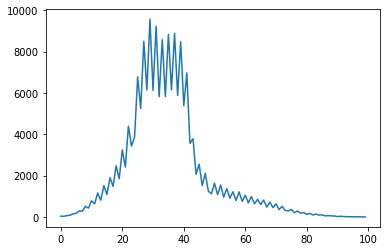

In [84]:
plt.plot(training_data[1])

In [85]:
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.fit(training_data, training_labels)
rbf_svc.score(test_data, test_labels)

0.696969696969697

In [93]:
from sklearn.ensemble import RandomForestClassifier 

rfc = RandomForestClassifier()
rfc.fit(training_data, training_labels)
rfc.score(test_data, test_labels)


0.7925407925407926

In [6]:
def loadBatch(img_df, batch_size=16):
    if len(img_df)<=batch_size:
        X = [imread(img_df.loc[i,'patch_filename']) for i in img_df.index.values.to_list()]
        Y = img_df.plastic.values.to_list()
    else:
        shuffled_ind = np.random.randi(0, img_df.index.max(), batch_size)
        X = [imread(img_df.loc[i,'patch_filename']) for i in shuffled_ind]
        Y = img_df.loc[shuffled_ind,'plastic'].values
        img_df = img_df.drop(img_df.index[shuffled_ind])
    return X, Y, img_df

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/giorgia/Desktop/MAI/Thesis/images/patches/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/giorgia/Desktop/MAI/Thesis/images/patches/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: No images found in directory /home/giorgia/Desktop/MAI/Thesis/images/patches/. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [13]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomTranslation(0.8, 0.5),
      layers.RandomZoom(0.5),
      layers.RandomHeight(0.1),
      layers.RandomWidth(0.2),
      layers.RandomContrast(0.7),
    ]
)

2022-02-03 17:40:16.985726: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-03 17:40:16.985787: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (giorgia-PX60-6QE): /proc/driver/nvidia/version does not exist
2022-02-03 17:40:17.044630: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [37]:
def prepareDataNN(df):
    data = []
    labels = []
    patches_path = '/home/giorgia/Desktop/MAI/Thesis/images/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        #im = np.amax(imread(patch_filename), axis=2) # maximum intensity projection
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            data.append(im)
            labels.append(np.array(df.loc[i, 'plastic']))
    return data, labels

In [47]:
training_data, training_labels = prepareDataNN(training_set)
test_data, test_labels = prepareDataNN(validation_set)
training_data += test_data
training_labels += test_labels

In [50]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    x=np.array(training_data), y=np.array(training_labels) , epochs=epochs, callbacks=callbacks, validation_split=.15
)

Epoch 1/50
 1/36 [..............................] - ETA: 4:00 - loss: 0.9105 - accuracy: 0.5625